In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.regularizers import l2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
lstm_units = 50
w_decay = 0.05
dropout_rate = 0.2
epochs_to_run = 500
sequence_length = 200

In [3]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [4]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

141148


In [5]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [6]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [7]:
def nlp_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm = Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate))(embedding)
    output = Dense(units=1, activation='sigmoid')(lstm)

    model = Model(inputs, output)
    return model


model = nlp_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm1.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history1 = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14114800  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 14,175,301
Trainable params: 60,501
Non-trainable params: 14,114,800
_________________________________________________________________
Epoch 1/500
130/133 [============================>.] - ETA: 0s - loss: 16.8093 - accuracy: 0.5356
Epoch 00001: val_accuracy improved from -inf to 0.59112, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [=========================

133/133 [==============================] - 3s 22ms/step - loss: 0.5458 - accuracy: 0.8043 - val_loss: 0.5090 - val_accuracy: 0.8357
Epoch 24/500
130/133 [============================>.] - ETA: 0s - loss: 0.5404 - accuracy: 0.8048
Epoch 00024: val_accuracy did not improve from 0.83569
133/133 [==============================] - 3s 21ms/step - loss: 0.5400 - accuracy: 0.8055 - val_loss: 0.5055 - val_accuracy: 0.8263
Epoch 25/500
130/133 [============================>.] - ETA: 0s - loss: 0.5336 - accuracy: 0.8091
Epoch 00025: val_accuracy did not improve from 0.83569
133/133 [==============================] - 3s 21ms/step - loss: 0.5353 - accuracy: 0.8086 - val_loss: 0.5017 - val_accuracy: 0.8338
Epoch 26/500
133/133 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.8155
Epoch 00026: val_accuracy did not improve from 0.83569
133/133 [==============================] - 3s 21ms/step - loss: 0.5258 - accuracy: 0.8155 - val_loss: 0.5018 - val_accuracy: 0.8319
Epoch 27/500


Epoch 52/500
130/133 [============================>.] - ETA: 0s - loss: 0.4603 - accuracy: 0.8416
Epoch 00052: val_accuracy did not improve from 0.84891
133/133 [==============================] - 3s 20ms/step - loss: 0.4593 - accuracy: 0.8422 - val_loss: 0.4450 - val_accuracy: 0.8414
Epoch 53/500
130/133 [============================>.] - ETA: 0s - loss: 0.4582 - accuracy: 0.8430
Epoch 00053: val_accuracy did not improve from 0.84891
133/133 [==============================] - 3s 20ms/step - loss: 0.4579 - accuracy: 0.8433 - val_loss: 0.4435 - val_accuracy: 0.8423
Epoch 54/500
133/133 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.8455
Epoch 00054: val_accuracy improved from 0.84891 to 0.84986, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 3s 22ms/step - loss: 0.4578 - accuracy: 0.8455 - val_loss: 0.4404 - val_accuracy: 0.8499
Epoch 55/500
130/133 [============================>.] - ETA: 0s - loss: 0.4559 - accuracy: 0.8

130/133 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8606
Epoch 00080: val_accuracy improved from 0.85552 to 0.85741, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 3s 22ms/step - loss: 0.4278 - accuracy: 0.8594 - val_loss: 0.4160 - val_accuracy: 0.8574
Epoch 81/500
130/133 [============================>.] - ETA: 0s - loss: 0.4203 - accuracy: 0.8637
Epoch 00081: val_accuracy improved from 0.85741 to 0.86402, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 3s 22ms/step - loss: 0.4190 - accuracy: 0.8646 - val_loss: 0.4139 - val_accuracy: 0.8640
Epoch 82/500
130/133 [============================>.] - ETA: 0s - loss: 0.4158 - accuracy: 0.8632
Epoch 00082: val_accuracy did not improve from 0.86402
133/133 [==============================] - 3s 20ms/step - loss: 0.4155 - accuracy: 0.8634 - val_loss: 0.4127 - val_accuracy: 0.8565
Epoch 83/500
133/133 [==============================] - 

Epoch 108/500
130/133 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.8805
Epoch 00108: val_accuracy did not improve from 0.87158
133/133 [==============================] - 3s 20ms/step - loss: 0.3917 - accuracy: 0.8811 - val_loss: 0.3975 - val_accuracy: 0.8716
Epoch 109/500
130/133 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.8760
Epoch 00109: val_accuracy did not improve from 0.87158
133/133 [==============================] - 3s 20ms/step - loss: 0.3862 - accuracy: 0.8752 - val_loss: 0.4087 - val_accuracy: 0.8593
Epoch 110/500
130/133 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8798
Epoch 00110: val_accuracy did not improve from 0.87158
133/133 [==============================] - 3s 20ms/step - loss: 0.3895 - accuracy: 0.8807 - val_loss: 0.4007 - val_accuracy: 0.8631
Epoch 111/500
130/133 [============================>.] - ETA: 0s - loss: 0.3890 - accuracy: 0.8851
Epoch 00111: val_accuracy did not improve f

130/133 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.8935
Epoch 00136: val_accuracy did not improve from 0.87630
133/133 [==============================] - 3s 20ms/step - loss: 0.3717 - accuracy: 0.8930 - val_loss: 0.3885 - val_accuracy: 0.8716
Epoch 137/500
130/133 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8887
Epoch 00137: val_accuracy did not improve from 0.87630
133/133 [==============================] - 3s 20ms/step - loss: 0.3690 - accuracy: 0.8897 - val_loss: 0.3903 - val_accuracy: 0.8744
Epoch 138/500
130/133 [============================>.] - ETA: 0s - loss: 0.3731 - accuracy: 0.8870
Epoch 00138: val_accuracy did not improve from 0.87630
133/133 [==============================] - 3s 20ms/step - loss: 0.3722 - accuracy: 0.8873 - val_loss: 0.3890 - val_accuracy: 0.8716
Epoch 139/500
130/133 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8865
Epoch 00139: val_accuracy improved from 0.87630 to 0.8772

Epoch 164/500
130/133 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.8923
Epoch 00164: val_accuracy did not improve from 0.88763
133/133 [==============================] - 3s 20ms/step - loss: 0.3534 - accuracy: 0.8932 - val_loss: 0.3825 - val_accuracy: 0.8716
Epoch 165/500
130/133 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8911
Epoch 00165: val_accuracy did not improve from 0.88763
133/133 [==============================] - 3s 20ms/step - loss: 0.3570 - accuracy: 0.8918 - val_loss: 0.3804 - val_accuracy: 0.8772
Epoch 166/500
130/133 [============================>.] - ETA: 0s - loss: 0.3471 - accuracy: 0.8988
Epoch 00166: val_accuracy did not improve from 0.88763
133/133 [==============================] - 3s 20ms/step - loss: 0.3500 - accuracy: 0.8972 - val_loss: 0.3813 - val_accuracy: 0.8801
Epoch 167/500
130/133 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.8882
Epoch 00167: val_accuracy did not improve f

Epoch 193/500
130/133 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.9005
Epoch 00193: val_accuracy did not improve from 0.88763
133/133 [==============================] - 3s 20ms/step - loss: 0.3377 - accuracy: 0.9010 - val_loss: 0.3860 - val_accuracy: 0.8772
Epoch 194/500
130/133 [============================>.] - ETA: 0s - loss: 0.3494 - accuracy: 0.8969
Epoch 00194: val_accuracy did not improve from 0.88763
133/133 [==============================] - 3s 20ms/step - loss: 0.3476 - accuracy: 0.8977 - val_loss: 0.3857 - val_accuracy: 0.8820
Epoch 195/500
130/133 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.9046
Epoch 00195: val_accuracy did not improve from 0.88763
133/133 [==============================] - 3s 20ms/step - loss: 0.3410 - accuracy: 0.9048 - val_loss: 0.3919 - val_accuracy: 0.8716
Epoch 196/500
132/133 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8956
Epoch 00196: val_accuracy did not improve f

Epoch 222/500
130/133 [============================>.] - ETA: 0s - loss: 0.3298 - accuracy: 0.9111
Epoch 00222: val_accuracy did not improve from 0.89046
133/133 [==============================] - 3s 20ms/step - loss: 0.3307 - accuracy: 0.9107 - val_loss: 0.3808 - val_accuracy: 0.8782
Epoch 223/500
130/133 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.9034
Epoch 00223: val_accuracy did not improve from 0.89046
133/133 [==============================] - 3s 20ms/step - loss: 0.3371 - accuracy: 0.9036 - val_loss: 0.3754 - val_accuracy: 0.8801
Epoch 224/500
130/133 [============================>.] - ETA: 0s - loss: 0.3267 - accuracy: 0.9101
Epoch 00224: val_accuracy did not improve from 0.89046
133/133 [==============================] - 3s 20ms/step - loss: 0.3280 - accuracy: 0.9095 - val_loss: 0.3758 - val_accuracy: 0.8754
Epoch 225/500
130/133 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.9079
Epoch 00225: val_accuracy did not improve f

Epoch 251/500
130/133 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.9103
Epoch 00251: val_accuracy did not improve from 0.89330
133/133 [==============================] - 3s 20ms/step - loss: 0.3177 - accuracy: 0.9114 - val_loss: 0.3744 - val_accuracy: 0.8905
Epoch 252/500
130/133 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.9115
Epoch 00252: val_accuracy did not improve from 0.89330
133/133 [==============================] - 3s 20ms/step - loss: 0.3151 - accuracy: 0.9116 - val_loss: 0.3726 - val_accuracy: 0.8886
Epoch 253/500
130/133 [============================>.] - ETA: 0s - loss: 0.3275 - accuracy: 0.9053
Epoch 00253: val_accuracy did not improve from 0.89330
133/133 [==============================] - 3s 20ms/step - loss: 0.3270 - accuracy: 0.9055 - val_loss: 0.3718 - val_accuracy: 0.8867
Epoch 254/500
130/133 [============================>.] - ETA: 0s - loss: 0.3139 - accuracy: 0.9111
Epoch 00254: val_accuracy did not improve f

Epoch 280/500
130/133 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.9125
Epoch 00280: val_accuracy did not improve from 0.89424
133/133 [==============================] - 3s 20ms/step - loss: 0.3150 - accuracy: 0.9126 - val_loss: 0.4147 - val_accuracy: 0.8697
Epoch 281/500
130/133 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.9127
Epoch 00281: val_accuracy did not improve from 0.89424
133/133 [==============================] - 3s 20ms/step - loss: 0.3131 - accuracy: 0.9130 - val_loss: 0.3826 - val_accuracy: 0.8857
Epoch 282/500
130/133 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.9151
Epoch 00282: val_accuracy did not improve from 0.89424
133/133 [==============================] - 3s 20ms/step - loss: 0.3182 - accuracy: 0.9145 - val_loss: 0.3701 - val_accuracy: 0.8895
Epoch 283/500
130/133 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.9113
Epoch 00283: val_accuracy did not improve f

Epoch 309/500
130/133 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.9187
Epoch 00309: val_accuracy did not improve from 0.89424
133/133 [==============================] - 3s 20ms/step - loss: 0.3091 - accuracy: 0.9194 - val_loss: 0.3943 - val_accuracy: 0.8687
Epoch 310/500
133/133 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.9204
Epoch 00310: val_accuracy did not improve from 0.89424
133/133 [==============================] - 3s 21ms/step - loss: 0.3021 - accuracy: 0.9204 - val_loss: 0.3754 - val_accuracy: 0.8839
Epoch 311/500
130/133 [============================>.] - ETA: 0s - loss: 0.3095 - accuracy: 0.9111
Epoch 00311: val_accuracy did not improve from 0.89424
133/133 [==============================] - 3s 20ms/step - loss: 0.3102 - accuracy: 0.9104 - val_loss: 0.3880 - val_accuracy: 0.8782
Epoch 312/500
130/133 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.9125
Epoch 00312: val_accuracy improved from 0.8

133/133 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.9178
Epoch 00337: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 21ms/step - loss: 0.3041 - accuracy: 0.9178 - val_loss: 0.3707 - val_accuracy: 0.8933
Epoch 338/500
130/133 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.9192
Epoch 00338: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 22ms/step - loss: 0.3012 - accuracy: 0.9187 - val_loss: 0.3892 - val_accuracy: 0.8810
Epoch 339/500
130/133 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.9236
Epoch 00339: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2953 - accuracy: 0.9239 - val_loss: 0.3704 - val_accuracy: 0.8924
Epoch 340/500
130/133 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.9209
Epoch 00340: val_accuracy did not improve from 0.89707
13

Epoch 366/500
130/133 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.9269
Epoch 00366: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2890 - accuracy: 0.9272 - val_loss: 0.3679 - val_accuracy: 0.8924
Epoch 367/500
130/133 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.9185
Epoch 00367: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2919 - accuracy: 0.9187 - val_loss: 0.3702 - val_accuracy: 0.8876
Epoch 368/500
133/133 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.9211
Epoch 00368: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2923 - accuracy: 0.9211 - val_loss: 0.3896 - val_accuracy: 0.8810
Epoch 369/500
133/133 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.9175
Epoch 00369: val_accuracy did not improve f

Epoch 395/500
130/133 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.9252
Epoch 00395: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2949 - accuracy: 0.9253 - val_loss: 0.3802 - val_accuracy: 0.8839
Epoch 396/500
130/133 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.9243
Epoch 00396: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2955 - accuracy: 0.9244 - val_loss: 0.3722 - val_accuracy: 0.8905
Epoch 397/500
130/133 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.9224
Epoch 00397: val_accuracy did not improve from 0.89707
133/133 [==============================] - 3s 20ms/step - loss: 0.2889 - accuracy: 0.9225 - val_loss: 0.3673 - val_accuracy: 0.8952
Epoch 398/500
130/133 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.9300
Epoch 00398: val_accuracy did not improve f

Epoch 424/500
133/133 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.9331
Epoch 00424: val_accuracy did not improve from 0.90085
133/133 [==============================] - 3s 20ms/step - loss: 0.2770 - accuracy: 0.9331 - val_loss: 0.3733 - val_accuracy: 0.8914
Epoch 425/500
131/133 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.9265
Epoch 00425: val_accuracy did not improve from 0.90085
133/133 [==============================] - 3s 19ms/step - loss: 0.2820 - accuracy: 0.9272 - val_loss: 0.3892 - val_accuracy: 0.8772
Epoch 426/500
130/133 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.9262
Epoch 00426: val_accuracy did not improve from 0.90085
133/133 [==============================] - 3s 19ms/step - loss: 0.2841 - accuracy: 0.9260 - val_loss: 0.3679 - val_accuracy: 0.8886
Epoch 427/500
133/133 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.9260
Epoch 00427: val_accuracy did not improve f

Epoch 453/500
130/133 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.9325
Epoch 00453: val_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 20ms/step - loss: 0.2835 - accuracy: 0.9317 - val_loss: 0.4390 - val_accuracy: 0.8602
Epoch 454/500
133/133 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9256
Epoch 00454: val_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 20ms/step - loss: 0.2806 - accuracy: 0.9256 - val_loss: 0.3754 - val_accuracy: 0.8829
Epoch 455/500
133/133 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.9284
Epoch 00455: val_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 20ms/step - loss: 0.2787 - accuracy: 0.9284 - val_loss: 0.3813 - val_accuracy: 0.8876
Epoch 456/500
133/133 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9277
Epoch 00456: val_accuracy did not improve f

Epoch 482/500
133/133 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9263
Epoch 00482: val_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 20ms/step - loss: 0.2782 - accuracy: 0.9263 - val_loss: 0.3664 - val_accuracy: 0.8952
Epoch 483/500
133/133 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9310
Epoch 00483: val_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 20ms/step - loss: 0.2709 - accuracy: 0.9310 - val_loss: 0.3852 - val_accuracy: 0.8867
Epoch 484/500
133/133 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.9350
Epoch 00484: val_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 20ms/step - loss: 0.2712 - accuracy: 0.9350 - val_loss: 0.3844 - val_accuracy: 0.8857
Epoch 485/500
133/133 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.9234
Epoch 00485: val_accuracy did not improve f

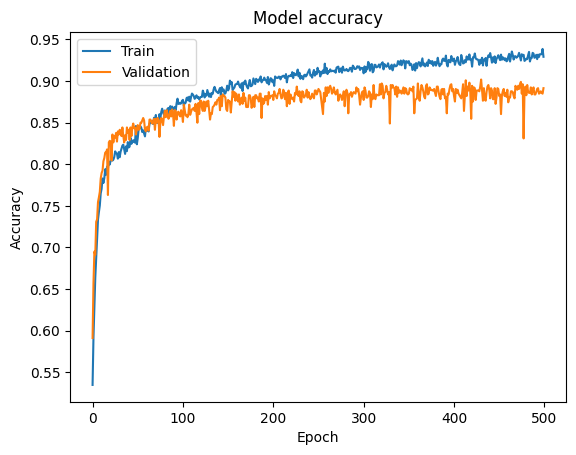

In [8]:
from matplotlib import pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model = load_model('./weight_cp/weight_lstm1.hdf5')
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Bidirectional LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Bidirectional LSTM
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       661
           1       0.89      0.89      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.889644746787604


In [10]:
def nlp_lstm2(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm = Bidirectional(LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate))(embedding)
    
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm[1])
    
    print(lstm[0].shape)
    
    sequence = lstm[0]
    
    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(sequence)
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(sequence)
    output_td = Flatten()(output_td)
    output_td = Multiply(name='recalibration')([output_td_gap, output_td])
    
    
    output_td_splits = tf.split(output_td, 10, axis=-1, name='split_calibrated')
    
    features = concatenate([output_td_splits[0], output_td_splits[-2], output_td_splits[-1]])
    
    features = Reshape((6, 10, 1))(features)
    
    print(features.shape, 'features shape')
    
    print(output_td.shape, 'output_td shape')
    
    output_td = Conv2D(4, 6, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(features)
    output_td = BatchNormalization()(output_td)
    output_td = MaxPooling2D(pool_size=(2, 2))(output_td)
    
    output_td = Conv2D(16, 3, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, [output, output_td, avg])
    return model


model = nlp_lstm2(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2.hdf5', save_freq="epoch",  verbose=1, monitor='val_avg_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history2 = model.fit(X_train, y_train,  epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

(None, 200, 100)
(None, 6, 10, 1) features shape
(None, 200) output_td shape
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14114800    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 200, 100), ( 60400       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 200, 1)       101         bidirectional_1[0][0]            
__________

Epoch 6/500
133/133 [==============================] - ETA: 0s - loss: 7.9341 - op_main_loss: 0.6037 - op_conv_loss: 0.4318 - avg_loss: 0.4843 - op_main_accuracy: 0.6931 - op_conv_accuracy: 0.8029 - avg_accuracy: 0.8065
Epoch 00006: val_avg_accuracy improved from 0.80264 to 0.81681, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 3s 25ms/step - loss: 7.9341 - op_main_loss: 0.6037 - op_conv_loss: 0.4318 - avg_loss: 0.4843 - op_main_accuracy: 0.6931 - op_conv_accuracy: 0.8029 - avg_accuracy: 0.8065 - val_loss: 7.3044 - val_op_main_loss: 0.5875 - val_op_conv_loss: 0.4195 - val_avg_loss: 0.4634 - val_op_main_accuracy: 0.7025 - val_op_conv_accuracy: 0.8149 - val_avg_accuracy: 0.8168
Epoch 7/500
133/133 [==============================] - ETA: 0s - loss: 6.7886 - op_main_loss: 0.5851 - op_conv_loss: 0.4001 - avg_loss: 0.4560 - op_main_accuracy: 0.7186 - op_conv_accuracy: 0.8223 - avg_accuracy: 0.8275
Epoch 00007: val_avg_accuracy improved from 0.81681 

Epoch 18/500
133/133 [==============================] - ETA: 0s - loss: 2.4000 - op_main_loss: 0.4633 - op_conv_loss: 0.2549 - avg_loss: 0.3243 - op_main_accuracy: 0.8010 - op_conv_accuracy: 0.8963 - avg_accuracy: 0.8970
Epoch 00018: val_avg_accuracy improved from 0.86686 to 0.86969, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 3s 25ms/step - loss: 2.4000 - op_main_loss: 0.4633 - op_conv_loss: 0.2549 - avg_loss: 0.3243 - op_main_accuracy: 0.8010 - op_conv_accuracy: 0.8963 - avg_accuracy: 0.8970 - val_loss: 2.4215 - val_op_main_loss: 0.4423 - val_op_conv_loss: 0.3303 - val_avg_loss: 0.3403 - val_op_main_accuracy: 0.8064 - val_op_conv_accuracy: 0.8669 - val_avg_accuracy: 0.8697
Epoch 19/500
133/133 [==============================] - ETA: 0s - loss: 2.2732 - op_main_loss: 0.4541 - op_conv_loss: 0.2399 - avg_loss: 0.3131 - op_main_accuracy: 0.8055 - op_conv_accuracy: 0.9076 - avg_accuracy: 0.9029
Epoch 00019: val_avg_accuracy did not improve from

Epoch 30/500
132/133 [============================>.] - ETA: 0s - loss: 1.6579 - op_main_loss: 0.3965 - op_conv_loss: 0.1996 - avg_loss: 0.2629 - op_main_accuracy: 0.8329 - op_conv_accuracy: 0.9181 - avg_accuracy: 0.9231
Epoch 00030: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 3s 23ms/step - loss: 1.6588 - op_main_loss: 0.3966 - op_conv_loss: 0.2001 - avg_loss: 0.2632 - op_main_accuracy: 0.8327 - op_conv_accuracy: 0.9180 - avg_accuracy: 0.9227 - val_loss: 1.8871 - val_op_main_loss: 0.3790 - val_op_conv_loss: 0.3947 - val_avg_loss: 0.3253 - val_op_main_accuracy: 0.8395 - val_op_conv_accuracy: 0.8631 - val_avg_accuracy: 0.8650
Epoch 31/500
133/133 [==============================] - ETA: 0s - loss: 1.6216 - op_main_loss: 0.3923 - op_conv_loss: 0.1927 - avg_loss: 0.2589 - op_main_accuracy: 0.8320 - op_conv_accuracy: 0.9208 - avg_accuracy: 0.9197
Epoch 00031: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] -

132/133 [============================>.] - ETA: 0s - loss: 1.3942 - op_main_loss: 0.3658 - op_conv_loss: 0.1646 - avg_loss: 0.2328 - op_main_accuracy: 0.8428 - op_conv_accuracy: 0.9323 - avg_accuracy: 0.9299
Epoch 00042: val_avg_accuracy did not improve from 0.89330
133/133 [==============================] - 3s 23ms/step - loss: 1.3936 - op_main_loss: 0.3653 - op_conv_loss: 0.1645 - avg_loss: 0.2326 - op_main_accuracy: 0.8431 - op_conv_accuracy: 0.9324 - avg_accuracy: 0.9301 - val_loss: 1.8761 - val_op_main_loss: 0.3475 - val_op_conv_loss: 0.5715 - val_avg_loss: 0.3307 - val_op_main_accuracy: 0.8546 - val_op_conv_accuracy: 0.8159 - val_avg_accuracy: 0.8517
Epoch 43/500
133/133 [==============================] - ETA: 0s - loss: 1.3947 - op_main_loss: 0.3616 - op_conv_loss: 0.1762 - avg_loss: 0.2357 - op_main_accuracy: 0.8431 - op_conv_accuracy: 0.9301 - avg_accuracy: 0.9282
Epoch 00043: val_avg_accuracy did not improve from 0.89330
133/133 [==============================] - 3s 23ms/step

133/133 [==============================] - ETA: 0s - loss: 1.2716 - op_main_loss: 0.3422 - op_conv_loss: 0.1622 - avg_loss: 0.2199 - op_main_accuracy: 0.8518 - op_conv_accuracy: 0.9298 - avg_accuracy: 0.9286
Epoch 00054: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 3s 23ms/step - loss: 1.2716 - op_main_loss: 0.3422 - op_conv_loss: 0.1622 - avg_loss: 0.2199 - op_main_accuracy: 0.8518 - op_conv_accuracy: 0.9298 - avg_accuracy: 0.9286 - val_loss: 1.4387 - val_op_main_loss: 0.3322 - val_op_conv_loss: 0.2913 - val_avg_loss: 0.2706 - val_op_main_accuracy: 0.8546 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.8952
Epoch 55/500
133/133 [==============================] - ETA: 0s - loss: 1.2521 - op_main_loss: 0.3418 - op_conv_loss: 0.1519 - avg_loss: 0.2160 - op_main_accuracy: 0.8528 - op_conv_accuracy: 0.9390 - avg_accuracy: 0.9364
Epoch 00055: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 3s 23ms/step

132/133 [============================>.] - ETA: 0s - loss: 1.1654 - op_main_loss: 0.3194 - op_conv_loss: 0.1472 - avg_loss: 0.2022 - op_main_accuracy: 0.8700 - op_conv_accuracy: 0.9425 - avg_accuracy: 0.9375
Epoch 00066: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 23ms/step - loss: 1.1658 - op_main_loss: 0.3197 - op_conv_loss: 0.1472 - avg_loss: 0.2023 - op_main_accuracy: 0.8700 - op_conv_accuracy: 0.9426 - avg_accuracy: 0.9374 - val_loss: 1.8827 - val_op_main_loss: 0.3233 - val_op_conv_loss: 0.7191 - val_avg_loss: 0.3456 - val_op_main_accuracy: 0.8584 - val_op_conv_accuracy: 0.7913 - val_avg_accuracy: 0.8329
Epoch 67/500
133/133 [==============================] - ETA: 0s - loss: 1.1778 - op_main_loss: 0.3245 - op_conv_loss: 0.1516 - avg_loss: 0.2086 - op_main_accuracy: 0.8665 - op_conv_accuracy: 0.9402 - avg_accuracy: 0.9381
Epoch 00067: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 3s 23ms/step

133/133 [==============================] - ETA: 0s - loss: 1.0840 - op_main_loss: 0.2996 - op_conv_loss: 0.1360 - avg_loss: 0.1882 - op_main_accuracy: 0.8804 - op_conv_accuracy: 0.9471 - avg_accuracy: 0.9475
Epoch 00078: val_avg_accuracy improved from 0.90274 to 0.90935, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 3s 25ms/step - loss: 1.0840 - op_main_loss: 0.2996 - op_conv_loss: 0.1360 - avg_loss: 0.1882 - op_main_accuracy: 0.8804 - op_conv_accuracy: 0.9471 - avg_accuracy: 0.9475 - val_loss: 1.3130 - val_op_main_loss: 0.3190 - val_op_conv_loss: 0.2812 - val_avg_loss: 0.2538 - val_op_main_accuracy: 0.8659 - val_op_conv_accuracy: 0.9046 - val_avg_accuracy: 0.9093
Epoch 79/500
132/133 [============================>.] - ETA: 0s - loss: 1.0951 - op_main_loss: 0.3073 - op_conv_loss: 0.1354 - avg_loss: 0.1944 - op_main_accuracy: 0.8795 - op_conv_accuracy: 0.9441 - avg_accuracy: 0.9434
Epoch 00079: val_avg_accuracy did not improve from 0.90935
133/

133/133 [==============================] - ETA: 0s - loss: 1.0470 - op_main_loss: 0.2904 - op_conv_loss: 0.1354 - avg_loss: 0.1856 - op_main_accuracy: 0.8871 - op_conv_accuracy: 0.9454 - avg_accuracy: 0.9454
Epoch 00090: val_avg_accuracy did not improve from 0.90935
133/133 [==============================] - 3s 23ms/step - loss: 1.0470 - op_main_loss: 0.2904 - op_conv_loss: 0.1354 - avg_loss: 0.1856 - op_main_accuracy: 0.8871 - op_conv_accuracy: 0.9454 - avg_accuracy: 0.9454 - val_loss: 1.5009 - val_op_main_loss: 0.3047 - val_op_conv_loss: 0.4735 - val_avg_loss: 0.2885 - val_op_main_accuracy: 0.8669 - val_op_conv_accuracy: 0.8565 - val_avg_accuracy: 0.8754
Epoch 91/500
133/133 [==============================] - ETA: 0s - loss: 1.0209 - op_main_loss: 0.2910 - op_conv_loss: 0.1181 - avg_loss: 0.1785 - op_main_accuracy: 0.8854 - op_conv_accuracy: 0.9513 - avg_accuracy: 0.9473
Epoch 00091: val_avg_accuracy did not improve from 0.90935
133/133 [==============================] - 3s 23ms/step

133/133 [==============================] - ETA: 0s - loss: 1.0068 - op_main_loss: 0.2827 - op_conv_loss: 0.1284 - avg_loss: 0.1797 - op_main_accuracy: 0.8878 - op_conv_accuracy: 0.9483 - avg_accuracy: 0.9466
Epoch 00102: val_avg_accuracy did not improve from 0.90935
133/133 [==============================] - 3s 23ms/step - loss: 1.0068 - op_main_loss: 0.2827 - op_conv_loss: 0.1284 - avg_loss: 0.1797 - op_main_accuracy: 0.8878 - op_conv_accuracy: 0.9483 - avg_accuracy: 0.9466 - val_loss: 1.4098 - val_op_main_loss: 0.3024 - val_op_conv_loss: 0.4114 - val_avg_loss: 0.2811 - val_op_main_accuracy: 0.8744 - val_op_conv_accuracy: 0.8801 - val_avg_accuracy: 0.8791
Epoch 103/500
133/133 [==============================] - ETA: 0s - loss: 0.9831 - op_main_loss: 0.2738 - op_conv_loss: 0.1230 - avg_loss: 0.1722 - op_main_accuracy: 0.8930 - op_conv_accuracy: 0.9527 - avg_accuracy: 0.9499
Epoch 00103: val_avg_accuracy did not improve from 0.90935
133/133 [==============================] - 3s 25ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.9386 - op_main_loss: 0.2603 - op_conv_loss: 0.1145 - avg_loss: 0.1634 - op_main_accuracy: 0.9010 - op_conv_accuracy: 0.9524 - avg_accuracy: 0.9545
Epoch 00114: val_avg_accuracy improved from 0.90935 to 0.91029, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 3s 26ms/step - loss: 0.9383 - op_main_loss: 0.2602 - op_conv_loss: 0.1144 - avg_loss: 0.1633 - op_main_accuracy: 0.9012 - op_conv_accuracy: 0.9525 - avg_accuracy: 0.9546 - val_loss: 1.2602 - val_op_main_loss: 0.2897 - val_op_conv_loss: 0.3149 - val_avg_loss: 0.2555 - val_op_main_accuracy: 0.8735 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9103
Epoch 115/500
131/133 [============================>.] - ETA: 0s - loss: 0.9317 - op_main_loss: 0.2590 - op_conv_loss: 0.1117 - avg_loss: 0.1612 - op_main_accuracy: 0.8984 - op_conv_accuracy: 0.9573 - avg_accuracy: 0.9532
Epoch 00115: val_avg_accuracy did not improve from 0.91029
133

131/133 [============================>.] - ETA: 0s - loss: 0.9203 - op_main_loss: 0.2530 - op_conv_loss: 0.1184 - avg_loss: 0.1611 - op_main_accuracy: 0.9020 - op_conv_accuracy: 0.9544 - avg_accuracy: 0.9504
Epoch 00126: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 4s 26ms/step - loss: 0.9196 - op_main_loss: 0.2525 - op_conv_loss: 0.1186 - avg_loss: 0.1607 - op_main_accuracy: 0.9022 - op_conv_accuracy: 0.9544 - avg_accuracy: 0.9504 - val_loss: 1.2952 - val_op_main_loss: 0.2879 - val_op_conv_loss: 0.3611 - val_avg_loss: 0.2590 - val_op_main_accuracy: 0.8716 - val_op_conv_accuracy: 0.8905 - val_avg_accuracy: 0.8961
Epoch 127/500
132/133 [============================>.] - ETA: 0s - loss: 0.8899 - op_main_loss: 0.2452 - op_conv_loss: 0.1045 - avg_loss: 0.1538 - op_main_accuracy: 0.9053 - op_conv_accuracy: 0.9595 - avg_accuracy: 0.9590
Epoch 00127: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 26ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8951 - op_main_loss: 0.2468 - op_conv_loss: 0.1134 - avg_loss: 0.1582 - op_main_accuracy: 0.9050 - op_conv_accuracy: 0.9568 - avg_accuracy: 0.9523
Epoch 00138: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 26ms/step - loss: 0.8951 - op_main_loss: 0.2468 - op_conv_loss: 0.1134 - avg_loss: 0.1582 - op_main_accuracy: 0.9050 - op_conv_accuracy: 0.9568 - avg_accuracy: 0.9523 - val_loss: 1.2418 - val_op_main_loss: 0.2839 - val_op_conv_loss: 0.3236 - val_avg_loss: 0.2571 - val_op_main_accuracy: 0.8857 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9018
Epoch 139/500
133/133 [==============================] - ETA: 0s - loss: 0.8906 - op_main_loss: 0.2404 - op_conv_loss: 0.1175 - avg_loss: 0.1560 - op_main_accuracy: 0.9076 - op_conv_accuracy: 0.9523 - avg_accuracy: 0.9542
Epoch 00139: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 26ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8404 - op_main_loss: 0.2276 - op_conv_loss: 0.0997 - avg_loss: 0.1446 - op_main_accuracy: 0.9149 - op_conv_accuracy: 0.9610 - avg_accuracy: 0.9586
Epoch 00150: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 25ms/step - loss: 0.8404 - op_main_loss: 0.2276 - op_conv_loss: 0.0997 - avg_loss: 0.1446 - op_main_accuracy: 0.9149 - op_conv_accuracy: 0.9610 - avg_accuracy: 0.9586 - val_loss: 1.3026 - val_op_main_loss: 0.2977 - val_op_conv_loss: 0.3601 - val_avg_loss: 0.2770 - val_op_main_accuracy: 0.8706 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8905
Epoch 151/500
133/133 [==============================] - ETA: 0s - loss: 0.8684 - op_main_loss: 0.2337 - op_conv_loss: 0.1143 - avg_loss: 0.1529 - op_main_accuracy: 0.9090 - op_conv_accuracy: 0.9527 - avg_accuracy: 0.9509
Epoch 00151: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8221 - op_main_loss: 0.2232 - op_conv_loss: 0.0960 - avg_loss: 0.1413 - op_main_accuracy: 0.9185 - op_conv_accuracy: 0.9624 - avg_accuracy: 0.9610
Epoch 00162: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/step - loss: 0.8221 - op_main_loss: 0.2232 - op_conv_loss: 0.0960 - avg_loss: 0.1413 - op_main_accuracy: 0.9185 - op_conv_accuracy: 0.9624 - avg_accuracy: 0.9610 - val_loss: 1.3158 - val_op_main_loss: 0.2822 - val_op_conv_loss: 0.4020 - val_avg_loss: 0.2697 - val_op_main_accuracy: 0.8820 - val_op_conv_accuracy: 0.8848 - val_avg_accuracy: 0.8905
Epoch 163/500
133/133 [==============================] - ETA: 0s - loss: 0.8445 - op_main_loss: 0.2257 - op_conv_loss: 0.1097 - avg_loss: 0.1476 - op_main_accuracy: 0.9119 - op_conv_accuracy: 0.9551 - avg_accuracy: 0.9570
Epoch 00163: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.8126 - op_main_loss: 0.2141 - op_conv_loss: 0.1034 - avg_loss: 0.1399 - op_main_accuracy: 0.9214 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9607
Epoch 00174: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/step - loss: 0.8118 - op_main_loss: 0.2137 - op_conv_loss: 0.1033 - avg_loss: 0.1397 - op_main_accuracy: 0.9216 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9608 - val_loss: 1.5158 - val_op_main_loss: 0.3042 - val_op_conv_loss: 0.5340 - val_avg_loss: 0.3234 - val_op_main_accuracy: 0.8706 - val_op_conv_accuracy: 0.8640 - val_avg_accuracy: 0.8687
Epoch 175/500
133/133 [==============================] - ETA: 0s - loss: 0.8267 - op_main_loss: 0.2228 - op_conv_loss: 0.1051 - avg_loss: 0.1449 - op_main_accuracy: 0.9154 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9582
Epoch 00175: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.8039 - op_main_loss: 0.2117 - op_conv_loss: 0.1029 - avg_loss: 0.1408 - op_main_accuracy: 0.9201 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9612
Epoch 00186: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/step - loss: 0.8039 - op_main_loss: 0.2117 - op_conv_loss: 0.1029 - avg_loss: 0.1408 - op_main_accuracy: 0.9201 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9612 - val_loss: 1.2053 - val_op_main_loss: 0.2756 - val_op_conv_loss: 0.3286 - val_avg_loss: 0.2529 - val_op_main_accuracy: 0.8857 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.9046
Epoch 187/500
133/133 [==============================] - ETA: 0s - loss: 0.7948 - op_main_loss: 0.2101 - op_conv_loss: 0.1007 - avg_loss: 0.1362 - op_main_accuracy: 0.9187 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9605
Epoch 00187: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7565 - op_main_loss: 0.1995 - op_conv_loss: 0.0864 - avg_loss: 0.1272 - op_main_accuracy: 0.9246 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9646
Epoch 00198: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/step - loss: 0.7565 - op_main_loss: 0.1995 - op_conv_loss: 0.0864 - avg_loss: 0.1272 - op_main_accuracy: 0.9246 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9646 - val_loss: 1.2176 - val_op_main_loss: 0.2760 - val_op_conv_loss: 0.3455 - val_avg_loss: 0.2533 - val_op_main_accuracy: 0.8839 - val_op_conv_accuracy: 0.8971 - val_avg_accuracy: 0.8990
Epoch 199/500
133/133 [==============================] - ETA: 0s - loss: 0.7646 - op_main_loss: 0.2012 - op_conv_loss: 0.0914 - avg_loss: 0.1292 - op_main_accuracy: 0.9279 - op_conv_accuracy: 0.9638 - avg_accuracy: 0.9622
Epoch 00199: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7613 - op_main_loss: 0.1978 - op_conv_loss: 0.0954 - avg_loss: 0.1298 - op_main_accuracy: 0.9237 - op_conv_accuracy: 0.9627 - avg_accuracy: 0.9655
Epoch 00210: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/step - loss: 0.7613 - op_main_loss: 0.1978 - op_conv_loss: 0.0954 - avg_loss: 0.1298 - op_main_accuracy: 0.9237 - op_conv_accuracy: 0.9627 - avg_accuracy: 0.9655 - val_loss: 1.3926 - val_op_main_loss: 0.2808 - val_op_conv_loss: 0.4809 - val_avg_loss: 0.2924 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8782 - val_avg_accuracy: 0.8876
Epoch 211/500
133/133 [==============================] - ETA: 0s - loss: 0.7681 - op_main_loss: 0.1953 - op_conv_loss: 0.1026 - avg_loss: 0.1321 - op_main_accuracy: 0.9289 - op_conv_accuracy: 0.9624 - avg_accuracy: 0.9624
Epoch 00211: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7554 - op_main_loss: 0.1927 - op_conv_loss: 0.0992 - avg_loss: 0.1299 - op_main_accuracy: 0.9286 - op_conv_accuracy: 0.9624 - avg_accuracy: 0.9622
Epoch 00222: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/step - loss: 0.7554 - op_main_loss: 0.1927 - op_conv_loss: 0.0992 - avg_loss: 0.1299 - op_main_accuracy: 0.9286 - op_conv_accuracy: 0.9624 - avg_accuracy: 0.9622 - val_loss: 1.2998 - val_op_main_loss: 0.2824 - val_op_conv_loss: 0.4038 - val_avg_loss: 0.2795 - val_op_main_accuracy: 0.8867 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8905
Epoch 223/500
131/133 [============================>.] - ETA: 0s - loss: 0.7590 - op_main_loss: 0.1937 - op_conv_loss: 0.1002 - avg_loss: 0.1312 - op_main_accuracy: 0.9306 - op_conv_accuracy: 0.9625 - avg_accuracy: 0.9630
Epoch 00223: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 24ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7188 - op_main_loss: 0.1849 - op_conv_loss: 0.0817 - avg_loss: 0.1201 - op_main_accuracy: 0.9332 - op_conv_accuracy: 0.9678 - avg_accuracy: 0.9706
Epoch 00234: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/step - loss: 0.7205 - op_main_loss: 0.1857 - op_conv_loss: 0.0821 - avg_loss: 0.1205 - op_main_accuracy: 0.9327 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9700 - val_loss: 1.2473 - val_op_main_loss: 0.2706 - val_op_conv_loss: 0.3822 - val_avg_loss: 0.2629 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.9056
Epoch 235/500
133/133 [==============================] - ETA: 0s - loss: 0.7443 - op_main_loss: 0.1917 - op_conv_loss: 0.0946 - avg_loss: 0.1261 - op_main_accuracy: 0.9218 - op_conv_accuracy: 0.9620 - avg_accuracy: 0.9641
Epoch 00235: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7374 - op_main_loss: 0.1828 - op_conv_loss: 0.0988 - avg_loss: 0.1267 - op_main_accuracy: 0.9343 - op_conv_accuracy: 0.9601 - avg_accuracy: 0.9631
Epoch 00246: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.7374 - op_main_loss: 0.1828 - op_conv_loss: 0.0988 - avg_loss: 0.1267 - op_main_accuracy: 0.9343 - op_conv_accuracy: 0.9601 - avg_accuracy: 0.9631 - val_loss: 1.2378 - val_op_main_loss: 0.2719 - val_op_conv_loss: 0.3703 - val_avg_loss: 0.2663 - val_op_main_accuracy: 0.8942 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9065
Epoch 247/500
133/133 [==============================] - ETA: 0s - loss: 0.7368 - op_main_loss: 0.1842 - op_conv_loss: 0.0986 - avg_loss: 0.1254 - op_main_accuracy: 0.9341 - op_conv_accuracy: 0.9634 - avg_accuracy: 0.9631
Epoch 00247: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6968 - op_main_loss: 0.1743 - op_conv_loss: 0.0824 - avg_loss: 0.1151 - op_main_accuracy: 0.9344 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9702
Epoch 00258: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 25ms/step - loss: 0.6967 - op_main_loss: 0.1741 - op_conv_loss: 0.0826 - avg_loss: 0.1151 - op_main_accuracy: 0.9341 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9700 - val_loss: 1.3581 - val_op_main_loss: 0.2848 - val_op_conv_loss: 0.4532 - val_avg_loss: 0.2951 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.8754 - val_avg_accuracy: 0.8886
Epoch 259/500
131/133 [============================>.] - ETA: 0s - loss: 0.7153 - op_main_loss: 0.1795 - op_conv_loss: 0.0912 - avg_loss: 0.1201 - op_main_accuracy: 0.9354 - op_conv_accuracy: 0.9668 - avg_accuracy: 0.9671
Epoch 00259: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 24ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7138 - op_main_loss: 0.1789 - op_conv_loss: 0.0913 - avg_loss: 0.1216 - op_main_accuracy: 0.9315 - op_conv_accuracy: 0.9622 - avg_accuracy: 0.9617
Epoch 00270: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.7138 - op_main_loss: 0.1789 - op_conv_loss: 0.0913 - avg_loss: 0.1216 - op_main_accuracy: 0.9315 - op_conv_accuracy: 0.9622 - avg_accuracy: 0.9617 - val_loss: 1.1902 - val_op_main_loss: 0.2667 - val_op_conv_loss: 0.3436 - val_avg_loss: 0.2578 - val_op_main_accuracy: 0.8914 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9037
Epoch 271/500
133/133 [==============================] - ETA: 0s - loss: 0.6967 - op_main_loss: 0.1723 - op_conv_loss: 0.0868 - avg_loss: 0.1159 - op_main_accuracy: 0.9379 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9676
Epoch 00271: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7138 - op_main_loss: 0.1734 - op_conv_loss: 0.0992 - avg_loss: 0.1204 - op_main_accuracy: 0.9317 - op_conv_accuracy: 0.9608 - avg_accuracy: 0.9605
Epoch 00282: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.7138 - op_main_loss: 0.1734 - op_conv_loss: 0.0992 - avg_loss: 0.1204 - op_main_accuracy: 0.9317 - op_conv_accuracy: 0.9608 - avg_accuracy: 0.9605 - val_loss: 1.2355 - val_op_main_loss: 0.2708 - val_op_conv_loss: 0.3742 - val_avg_loss: 0.2697 - val_op_main_accuracy: 0.8942 - val_op_conv_accuracy: 0.8971 - val_avg_accuracy: 0.8999
Epoch 283/500
133/133 [==============================] - ETA: 0s - loss: 0.6870 - op_main_loss: 0.1679 - op_conv_loss: 0.0843 - avg_loss: 0.1148 - op_main_accuracy: 0.9400 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9688
Epoch 00283: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6658 - op_main_loss: 0.1626 - op_conv_loss: 0.0801 - avg_loss: 0.1076 - op_main_accuracy: 0.9409 - op_conv_accuracy: 0.9712 - avg_accuracy: 0.9693
Epoch 00294: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6658 - op_main_loss: 0.1626 - op_conv_loss: 0.0801 - avg_loss: 0.1076 - op_main_accuracy: 0.9409 - op_conv_accuracy: 0.9712 - avg_accuracy: 0.9693 - val_loss: 1.2454 - val_op_main_loss: 0.2731 - val_op_conv_loss: 0.3838 - val_avg_loss: 0.2741 - val_op_main_accuracy: 0.8924 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8933
Epoch 295/500
133/133 [==============================] - ETA: 0s - loss: 0.6747 - op_main_loss: 0.1642 - op_conv_loss: 0.0847 - avg_loss: 0.1111 - op_main_accuracy: 0.9388 - op_conv_accuracy: 0.9674 - avg_accuracy: 0.9667
Epoch 00295: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6746 - op_main_loss: 0.1613 - op_conv_loss: 0.0876 - avg_loss: 0.1141 - op_main_accuracy: 0.9449 - op_conv_accuracy: 0.9657 - avg_accuracy: 0.9641
Epoch 00306: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6746 - op_main_loss: 0.1613 - op_conv_loss: 0.0876 - avg_loss: 0.1141 - op_main_accuracy: 0.9449 - op_conv_accuracy: 0.9657 - avg_accuracy: 0.9641 - val_loss: 1.3225 - val_op_main_loss: 0.2728 - val_op_conv_loss: 0.4489 - val_avg_loss: 0.2889 - val_op_main_accuracy: 0.8924 - val_op_conv_accuracy: 0.8839 - val_avg_accuracy: 0.8876
Epoch 307/500
133/133 [==============================] - ETA: 0s - loss: 0.6872 - op_main_loss: 0.1613 - op_conv_loss: 0.0973 - avg_loss: 0.1159 - op_main_accuracy: 0.9395 - op_conv_accuracy: 0.9612 - avg_accuracy: 0.9646
Epoch 00307: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6703 - op_main_loss: 0.1641 - op_conv_loss: 0.0836 - avg_loss: 0.1115 - op_main_accuracy: 0.9355 - op_conv_accuracy: 0.9672 - avg_accuracy: 0.9669
Epoch 00318: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6703 - op_main_loss: 0.1641 - op_conv_loss: 0.0836 - avg_loss: 0.1115 - op_main_accuracy: 0.9355 - op_conv_accuracy: 0.9672 - avg_accuracy: 0.9669 - val_loss: 1.2025 - val_op_main_loss: 0.2660 - val_op_conv_loss: 0.3684 - val_avg_loss: 0.2573 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9027
Epoch 319/500
133/133 [==============================] - ETA: 0s - loss: 0.6874 - op_main_loss: 0.1626 - op_conv_loss: 0.0969 - avg_loss: 0.1173 - op_main_accuracy: 0.9419 - op_conv_accuracy: 0.9643 - avg_accuracy: 0.9660
Epoch 00319: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6712 - op_main_loss: 0.1615 - op_conv_loss: 0.0896 - avg_loss: 0.1124 - op_main_accuracy: 0.9383 - op_conv_accuracy: 0.9657 - avg_accuracy: 0.9648
Epoch 00330: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6712 - op_main_loss: 0.1615 - op_conv_loss: 0.0896 - avg_loss: 0.1124 - op_main_accuracy: 0.9383 - op_conv_accuracy: 0.9657 - avg_accuracy: 0.9648 - val_loss: 1.1824 - val_op_main_loss: 0.2688 - val_op_conv_loss: 0.3433 - val_avg_loss: 0.2629 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.8999 - val_avg_accuracy: 0.9018
Epoch 331/500
133/133 [==============================] - ETA: 0s - loss: 0.6377 - op_main_loss: 0.1497 - op_conv_loss: 0.0780 - avg_loss: 0.1026 - op_main_accuracy: 0.9454 - op_conv_accuracy: 0.9693 - avg_accuracy: 0.9705
Epoch 00331: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6657 - op_main_loss: 0.1547 - op_conv_loss: 0.0941 - avg_loss: 0.1117 - op_main_accuracy: 0.9442 - op_conv_accuracy: 0.9622 - avg_accuracy: 0.9648
Epoch 00342: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6657 - op_main_loss: 0.1547 - op_conv_loss: 0.0941 - avg_loss: 0.1117 - op_main_accuracy: 0.9442 - op_conv_accuracy: 0.9622 - avg_accuracy: 0.9648 - val_loss: 1.1453 - val_op_main_loss: 0.2621 - val_op_conv_loss: 0.3259 - val_avg_loss: 0.2529 - val_op_main_accuracy: 0.9037 - val_op_conv_accuracy: 0.9093 - val_avg_accuracy: 0.9112
Epoch 343/500
133/133 [==============================] - ETA: 0s - loss: 0.6607 - op_main_loss: 0.1527 - op_conv_loss: 0.0921 - avg_loss: 0.1107 - op_main_accuracy: 0.9445 - op_conv_accuracy: 0.9631 - avg_accuracy: 0.9643
Epoch 00343: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6480 - op_main_loss: 0.1529 - op_conv_loss: 0.0867 - avg_loss: 0.1066 - op_main_accuracy: 0.9438 - op_conv_accuracy: 0.9646 - avg_accuracy: 0.9683
Epoch 00354: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6480 - op_main_loss: 0.1529 - op_conv_loss: 0.0867 - avg_loss: 0.1066 - op_main_accuracy: 0.9438 - op_conv_accuracy: 0.9646 - avg_accuracy: 0.9683 - val_loss: 1.4950 - val_op_main_loss: 0.3290 - val_op_conv_loss: 0.5195 - val_avg_loss: 0.3445 - val_op_main_accuracy: 0.8659 - val_op_conv_accuracy: 0.8735 - val_avg_accuracy: 0.8801
Epoch 355/500
133/133 [==============================] - ETA: 0s - loss: 0.6588 - op_main_loss: 0.1545 - op_conv_loss: 0.0916 - avg_loss: 0.1105 - op_main_accuracy: 0.9423 - op_conv_accuracy: 0.9617 - avg_accuracy: 0.9638
Epoch 00355: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6158 - op_main_loss: 0.1410 - op_conv_loss: 0.0751 - avg_loss: 0.0983 - op_main_accuracy: 0.9539 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9700
Epoch 00366: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6158 - op_main_loss: 0.1410 - op_conv_loss: 0.0751 - avg_loss: 0.0983 - op_main_accuracy: 0.9539 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9700 - val_loss: 1.4997 - val_op_main_loss: 0.2636 - val_op_conv_loss: 0.6322 - val_avg_loss: 0.3030 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.8527 - val_avg_accuracy: 0.8782
Epoch 367/500
133/133 [==============================] - ETA: 0s - loss: 0.6440 - op_main_loss: 0.1519 - op_conv_loss: 0.0842 - avg_loss: 0.1072 - op_main_accuracy: 0.9457 - op_conv_accuracy: 0.9669 - avg_accuracy: 0.9662
Epoch 00367: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6228 - op_main_loss: 0.1428 - op_conv_loss: 0.0800 - avg_loss: 0.1008 - op_main_accuracy: 0.9485 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9700
Epoch 00378: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6228 - op_main_loss: 0.1428 - op_conv_loss: 0.0800 - avg_loss: 0.1008 - op_main_accuracy: 0.9485 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9700 - val_loss: 1.2466 - val_op_main_loss: 0.2827 - val_op_conv_loss: 0.3895 - val_avg_loss: 0.2753 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.9065 - val_avg_accuracy: 0.9046
Epoch 379/500
133/133 [==============================] - ETA: 0s - loss: 0.6254 - op_main_loss: 0.1426 - op_conv_loss: 0.0822 - avg_loss: 0.1018 - op_main_accuracy: 0.9513 - op_conv_accuracy: 0.9679 - avg_accuracy: 0.9681
Epoch 00379: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6225 - op_main_loss: 0.1406 - op_conv_loss: 0.0834 - avg_loss: 0.1016 - op_main_accuracy: 0.9506 - op_conv_accuracy: 0.9705 - avg_accuracy: 0.9693
Epoch 00390: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6225 - op_main_loss: 0.1406 - op_conv_loss: 0.0834 - avg_loss: 0.1016 - op_main_accuracy: 0.9506 - op_conv_accuracy: 0.9705 - avg_accuracy: 0.9693 - val_loss: 1.5032 - val_op_main_loss: 0.3088 - val_op_conv_loss: 0.5511 - val_avg_loss: 0.3465 - val_op_main_accuracy: 0.8820 - val_op_conv_accuracy: 0.8640 - val_avg_accuracy: 0.8763
Epoch 391/500
133/133 [==============================] - ETA: 0s - loss: 0.5971 - op_main_loss: 0.1361 - op_conv_loss: 0.0704 - avg_loss: 0.0939 - op_main_accuracy: 0.9584 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9740
Epoch 00391: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6238 - op_main_loss: 0.1435 - op_conv_loss: 0.0844 - avg_loss: 0.1028 - op_main_accuracy: 0.9509 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9676
Epoch 00402: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.6238 - op_main_loss: 0.1435 - op_conv_loss: 0.0844 - avg_loss: 0.1028 - op_main_accuracy: 0.9509 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9676 - val_loss: 1.2030 - val_op_main_loss: 0.2626 - val_op_conv_loss: 0.3827 - val_avg_loss: 0.2643 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.9065 - val_avg_accuracy: 0.9084
Epoch 403/500
133/133 [==============================] - ETA: 0s - loss: 0.6097 - op_main_loss: 0.1402 - op_conv_loss: 0.0774 - avg_loss: 0.0983 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9709
Epoch 00403: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5913 - op_main_loss: 0.1348 - op_conv_loss: 0.0714 - avg_loss: 0.0936 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9714
Epoch 00414: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5913 - op_main_loss: 0.1348 - op_conv_loss: 0.0714 - avg_loss: 0.0936 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9714 - val_loss: 1.3867 - val_op_main_loss: 0.3025 - val_op_conv_loss: 0.4713 - val_avg_loss: 0.3211 - val_op_main_accuracy: 0.8924 - val_op_conv_accuracy: 0.8942 - val_avg_accuracy: 0.8895
Epoch 415/500
133/133 [==============================] - ETA: 0s - loss: 0.5963 - op_main_loss: 0.1432 - op_conv_loss: 0.0665 - avg_loss: 0.0947 - op_main_accuracy: 0.9466 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9735
Epoch 00415: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5991 - op_main_loss: 0.1382 - op_conv_loss: 0.0735 - avg_loss: 0.0963 - op_main_accuracy: 0.9539 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9724
Epoch 00426: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5991 - op_main_loss: 0.1382 - op_conv_loss: 0.0735 - avg_loss: 0.0963 - op_main_accuracy: 0.9539 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9724 - val_loss: 1.2312 - val_op_main_loss: 0.2615 - val_op_conv_loss: 0.4051 - val_avg_loss: 0.2738 - val_op_main_accuracy: 0.9056 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8999
Epoch 427/500
133/133 [==============================] - ETA: 0s - loss: 0.5807 - op_main_loss: 0.1288 - op_conv_loss: 0.0711 - avg_loss: 0.0901 - op_main_accuracy: 0.9586 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9754
Epoch 00427: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5936 - op_main_loss: 0.1358 - op_conv_loss: 0.0742 - avg_loss: 0.0946 - op_main_accuracy: 0.9520 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9738
Epoch 00438: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5936 - op_main_loss: 0.1358 - op_conv_loss: 0.0742 - avg_loss: 0.0946 - op_main_accuracy: 0.9520 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9738 - val_loss: 3.2641 - val_op_main_loss: 0.2645 - val_op_conv_loss: 2.2461 - val_avg_loss: 0.4650 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.5788 - val_avg_accuracy: 0.7384
Epoch 439/500
133/133 [==============================] - ETA: 0s - loss: 0.5911 - op_main_loss: 0.1334 - op_conv_loss: 0.0758 - avg_loss: 0.0941 - op_main_accuracy: 0.9568 - op_conv_accuracy: 0.9719 - avg_accuracy: 0.9731
Epoch 00439: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5705 - op_main_loss: 0.1280 - op_conv_loss: 0.0669 - avg_loss: 0.0889 - op_main_accuracy: 0.9575 - op_conv_accuracy: 0.9759 - avg_accuracy: 0.9764
Epoch 00450: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5705 - op_main_loss: 0.1280 - op_conv_loss: 0.0669 - avg_loss: 0.0889 - op_main_accuracy: 0.9575 - op_conv_accuracy: 0.9759 - avg_accuracy: 0.9764 - val_loss: 1.2173 - val_op_main_loss: 0.2767 - val_op_conv_loss: 0.3775 - val_avg_loss: 0.2768 - val_op_main_accuracy: 0.8990 - val_op_conv_accuracy: 0.9093 - val_avg_accuracy: 0.9046
Epoch 451/500
133/133 [==============================] - ETA: 0s - loss: 0.5672 - op_main_loss: 0.1280 - op_conv_loss: 0.0662 - avg_loss: 0.0877 - op_main_accuracy: 0.9612 - op_conv_accuracy: 0.9776 - avg_accuracy: 0.9771
Epoch 00451: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5868 - op_main_loss: 0.1349 - op_conv_loss: 0.0735 - avg_loss: 0.0943 - op_main_accuracy: 0.9513 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9719
Epoch 00462: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5868 - op_main_loss: 0.1349 - op_conv_loss: 0.0735 - avg_loss: 0.0943 - op_main_accuracy: 0.9513 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9719 - val_loss: 1.2539 - val_op_main_loss: 0.2623 - val_op_conv_loss: 0.4309 - val_avg_loss: 0.2762 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.8914 - val_avg_accuracy: 0.8942
Epoch 463/500
133/133 [==============================] - ETA: 0s - loss: 0.5809 - op_main_loss: 0.1300 - op_conv_loss: 0.0739 - avg_loss: 0.0925 - op_main_accuracy: 0.9570 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9740
Epoch 00463: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5921 - op_main_loss: 0.1330 - op_conv_loss: 0.0801 - avg_loss: 0.0965 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9702
Epoch 00474: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5921 - op_main_loss: 0.1330 - op_conv_loss: 0.0801 - avg_loss: 0.0965 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9702 - val_loss: 1.4879 - val_op_main_loss: 0.3318 - val_op_conv_loss: 0.5254 - val_avg_loss: 0.3483 - val_op_main_accuracy: 0.8810 - val_op_conv_accuracy: 0.8867 - val_avg_accuracy: 0.8895
Epoch 475/500
133/133 [==============================] - ETA: 0s - loss: 0.5820 - op_main_loss: 0.1340 - op_conv_loss: 0.0719 - avg_loss: 0.0936 - op_main_accuracy: 0.9534 - op_conv_accuracy: 0.9724 - avg_accuracy: 0.9728
Epoch 00475: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5852 - op_main_loss: 0.1296 - op_conv_loss: 0.0799 - avg_loss: 0.0943 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9702
Epoch 00486: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5852 - op_main_loss: 0.1296 - op_conv_loss: 0.0799 - avg_loss: 0.0943 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9702 - val_loss: 1.5224 - val_op_main_loss: 0.3338 - val_op_conv_loss: 0.5470 - val_avg_loss: 0.3603 - val_op_main_accuracy: 0.8754 - val_op_conv_accuracy: 0.8801 - val_avg_accuracy: 0.8782
Epoch 487/500
133/133 [==============================] - ETA: 0s - loss: 0.5764 - op_main_loss: 0.1294 - op_conv_loss: 0.0732 - avg_loss: 0.0922 - op_main_accuracy: 0.9553 - op_conv_accuracy: 0.9683 - avg_accuracy: 0.9714
Epoch 00487: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5697 - op_main_loss: 0.1277 - op_conv_loss: 0.0700 - avg_loss: 0.0916 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9719 - avg_accuracy: 0.9742
Epoch 00498: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/step - loss: 0.5697 - op_main_loss: 0.1277 - op_conv_loss: 0.0700 - avg_loss: 0.0916 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9719 - avg_accuracy: 0.9742 - val_loss: 1.2633 - val_op_main_loss: 0.2739 - val_op_conv_loss: 0.4224 - val_avg_loss: 0.2866 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.8952
Epoch 499/500
133/133 [==============================] - ETA: 0s - loss: 0.5630 - op_main_loss: 0.1220 - op_conv_loss: 0.0717 - avg_loss: 0.0886 - op_main_accuracy: 0.9617 - op_conv_accuracy: 0.9705 - avg_accuracy: 0.9754
Epoch 00499: val_avg_accuracy did not improve from 0.91785
133/133 [==============================] - 3s 23ms/ste

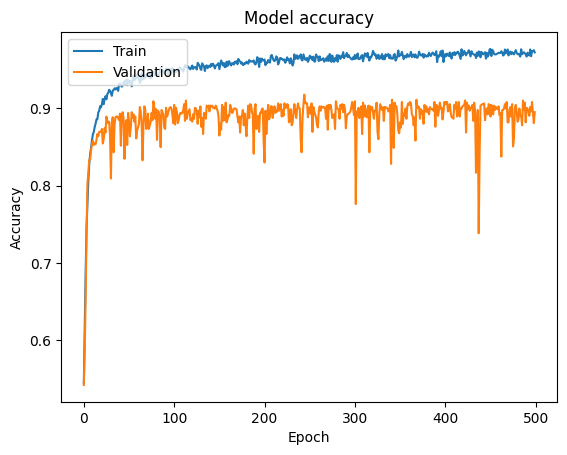

In [11]:
from matplotlib import pyplot as plt
plt.plot(history2.history['avg_accuracy'])
plt.plot(history2.history['val_avg_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

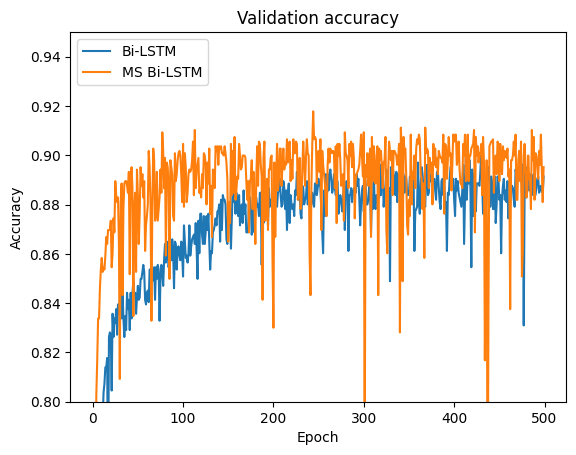

In [12]:
from matplotlib import pyplot as plt
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_avg_accuracy'])
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.95)
plt.legend(['Bi-LSTM', 'MS Bi-LSTM'], loc='upper left')
plt.show()

In [13]:
model = load_model('./weight_cp/weight_lstm2.hdf5')
predictionss = model.predict(X_test)


In [14]:
predictions = np.where(predictionss[-1] > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Multi-Supervised Bidirectional LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Multi-Supervised Bidirectional LSTM
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       661
           1       0.91      0.90      0.90       662

    accuracy                           0.90      1323
   macro avg       0.90      0.90      0.90      1323
weighted avg       0.90      0.90      0.90      1323

0.9032501889644747


In [15]:
for i, layer in enumerate(model.layers):
    print(layer.name, i)

input_2 0
embedding_1 1
bidirectional_1 2
time_distributed 3
global_average_pooling1d 4
flatten 5
recalibration 6
tf_op_layer_split_calibrated 7
concatenate 8
reshape 9
conv2d 10
batch_normalization 11
max_pooling2d 12
conv2d_1 13
batch_normalization_1 14
flatten_1 15
op_main 16
op_conv 17
avg 18


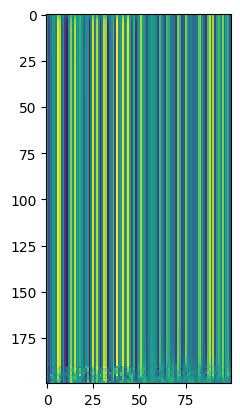

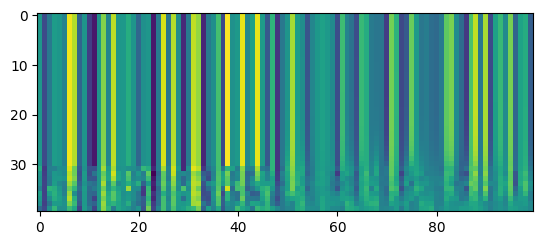

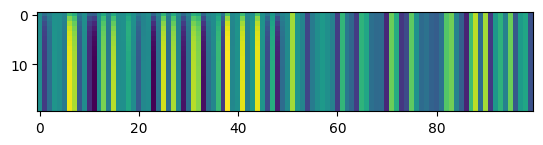

In [16]:
p = 1
f = Model(model.input, model.layers[2].output)
predictions = f.predict(X_test[0:109])[0]

plt.imshow(predictions[p], cmap='viridis', interpolation='nearest')
plt.show()

plt.imshow(predictions[p][160:200], cmap='viridis', interpolation='nearest')
plt.show()

plt.imshow(predictions[p][0:20], cmap='viridis', interpolation='nearest')
plt.show()

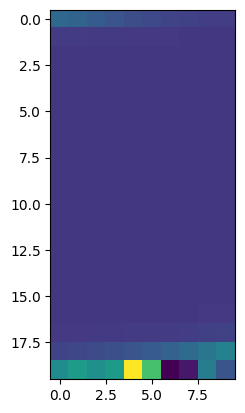

In [17]:
f = Model(model.input, model.layers[6].output)
predictions = f.predict(X_test[0:109])

plt.imshow(predictions[p].reshape((20, 10)), cmap='viridis', interpolation='nearest')
plt.show()

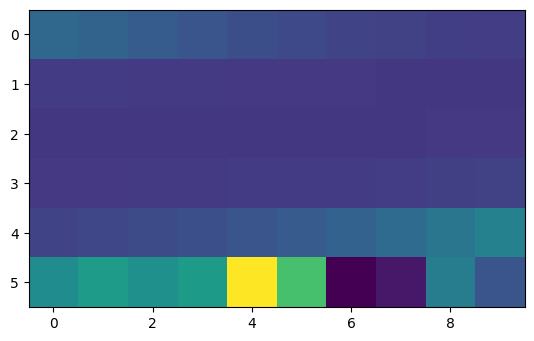

In [18]:
f = Model(model.input, model.layers[9].output)
predictions = f.predict(X_test[0:109])

plt.imshow(predictions[p], cmap='viridis', interpolation='nearest')
plt.show()

(10, 6, 10, 4)


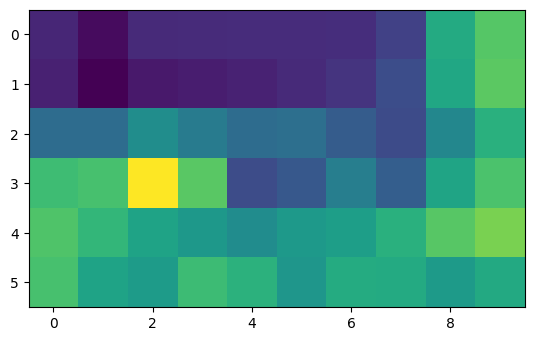

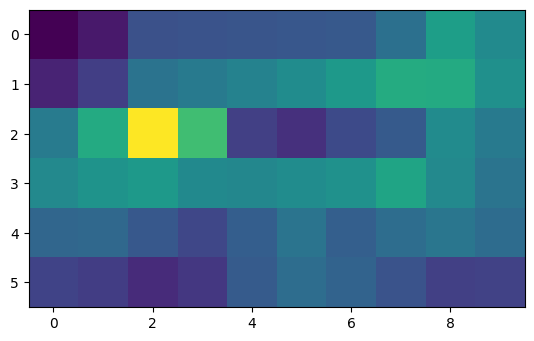

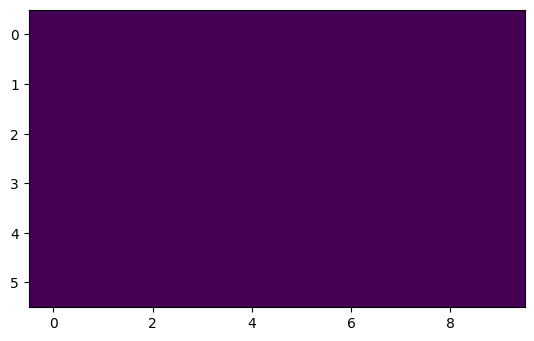

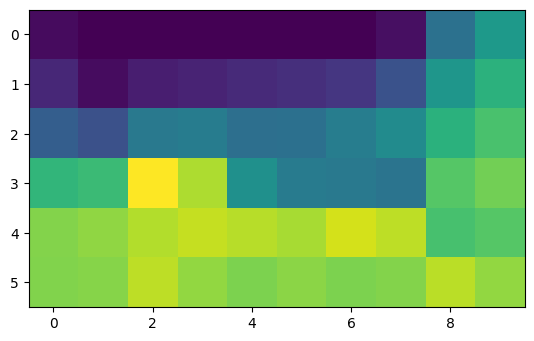

In [19]:
f = Model(model.input, model.layers[10].output)
predictions = f.predict(X_test[0:10])
print(predictions.shape)
for i in range(0, 4):
    plt.imshow(predictions[p][:, :, i], cmap='viridis', interpolation='nearest')
    plt.show()


(10, 3, 5, 16)


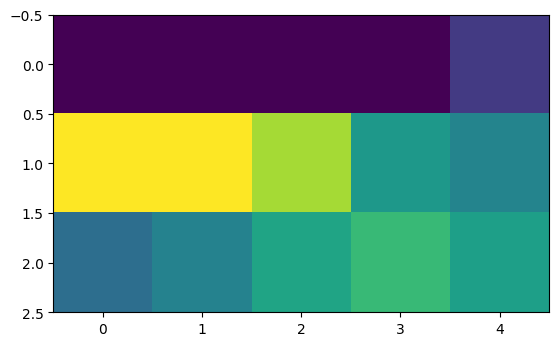

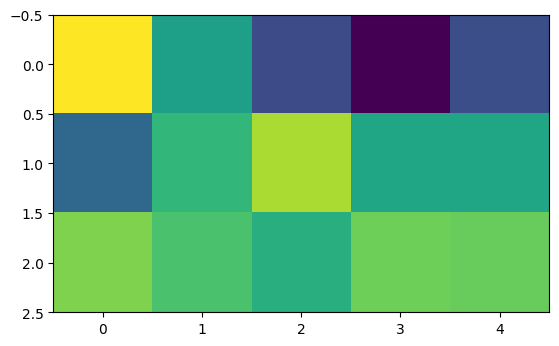

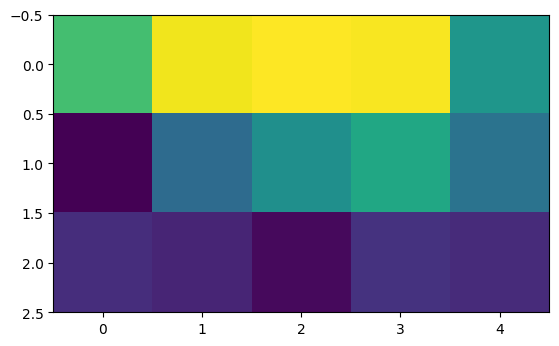

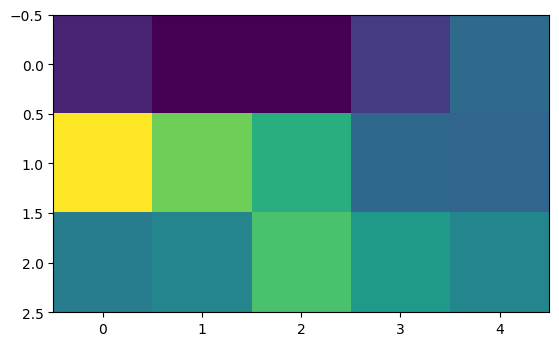

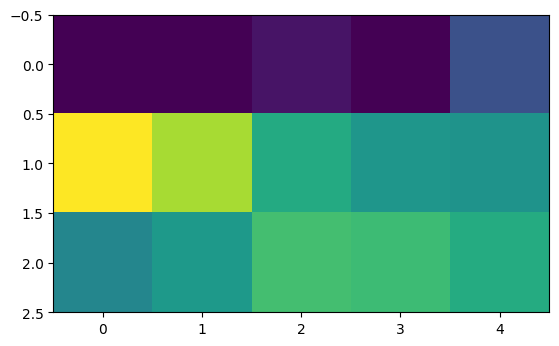

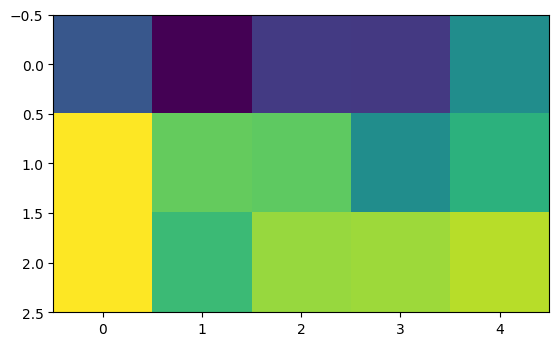

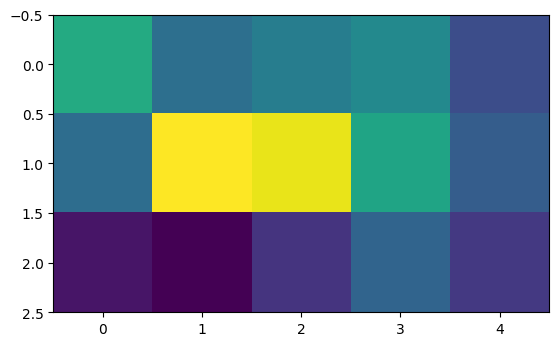

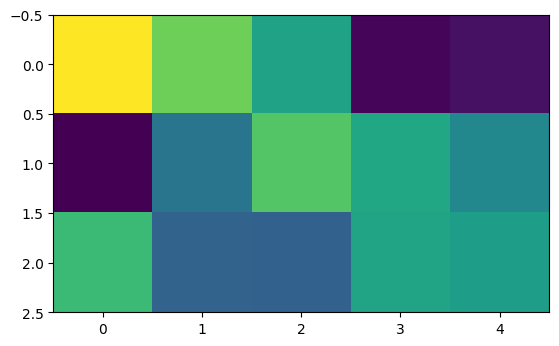

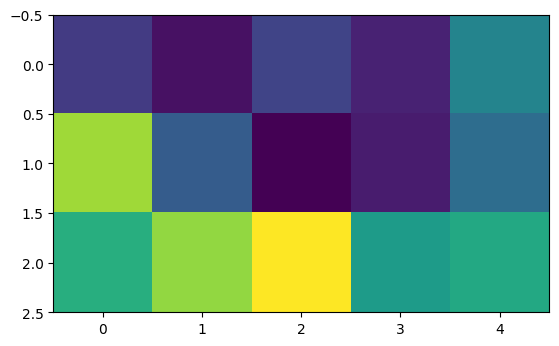

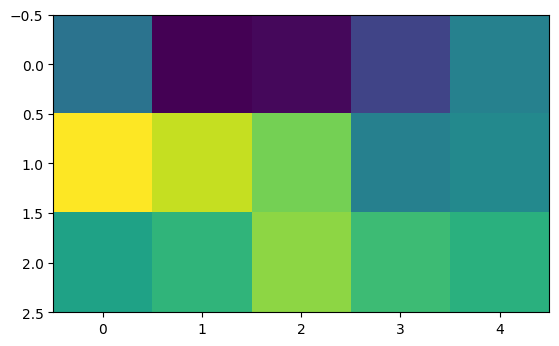

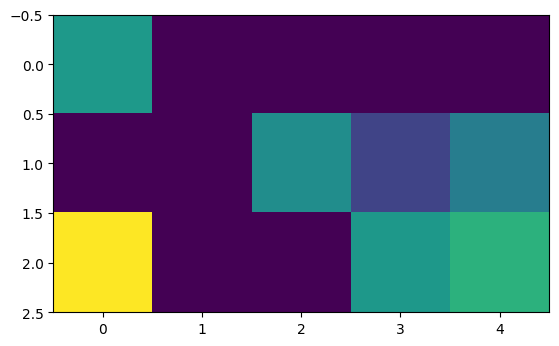

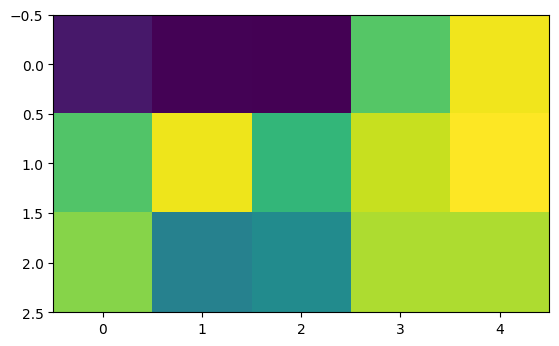

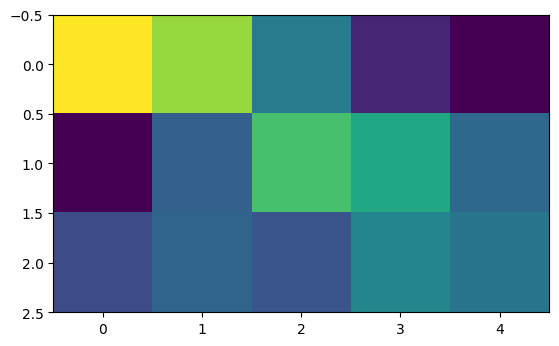

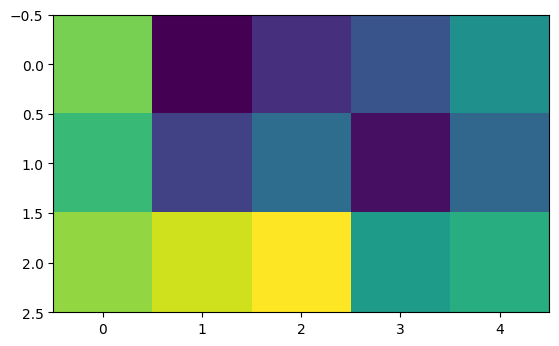

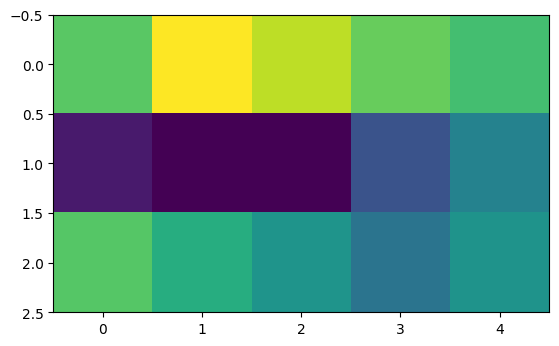

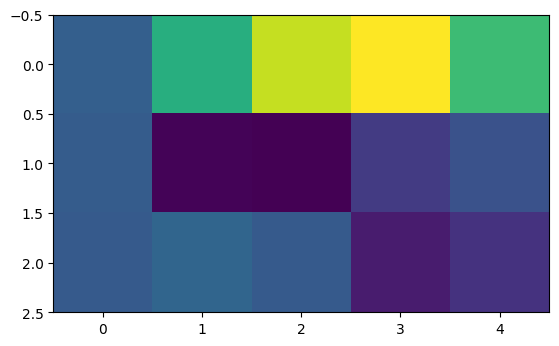

In [20]:
f = Model(model.input, model.layers[13].output)
predictions = f.predict(X_test[0:10])
print(predictions.shape)
for i in range(0, 16):
    plt.imshow(predictions[p][:, :, i], cmap='viridis', interpolation='nearest')
    plt.show()
